In [1]:
import os
from os.path import join
import sys
import numpy as np 
import pandas as pd
import seaborn as sns

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Eye Bias Analysis
Test whether there is a bias toward either the left or right eye. Test whether eye bias can be predicted by gender, handedness, or image category

#### **Note:** "left" is relative to the viewer (i.e. the 'right' anatomically)

In [4]:
# load the combined cursorTracking data for all subjs
df = pd.read_table('../../data/groupData/allSubjs_cursorTracking.tsv', sep='\t')

In [5]:
df.shape

(608261, 7)

In [6]:
df.head()

,ts,x,y,subjID,stim,trialNum,AOI
0,98,461.5,131.0,27235,_images707/bw_hmn/bw_hmn_wm02.jpg,1,none
1,123,461.5,131.0,27235,_images707/bw_hmn/bw_hmn_wm02.jpg,1,none
2,154,461.5,131.0,27235,_images707/bw_hmn/bw_hmn_wm02.jpg,1,none
3,172,461.5,131.0,27235,_images707/bw_hmn/bw_hmn_wm02.jpg,1,none
4,188,461.5,131.0,27235,_images707/bw_hmn/bw_hmn_wm02.jpg,1,none


### Select the stimuli to include in analysis
Choose the various categories of face and face-like stimuli

In [7]:
# function to label the image categories
def labelStimCategory(row):
    if ("_images707/bw_hmn/" in row['stim']) |  ("_images707/hmn/" in row['stim']):
        label = 'human'
    elif "_images707/animal/" in row['stim']:
        label = 'animal'
    elif "_images707/FLO/" in row['stim']:
        label = 'FLO'
    elif "_images707/art/Port_" in row['stim']:
        label = 'portrait'
    elif "_images707/faceFood/" in row['stim']:
        label = 'faceFood'
    else:
        label = "Na"
    
    return label

In [8]:
# add image category label to dataframe
df['stimCategory'] = df.apply(labelStimCategory, axis=1)

In [9]:
# make sure this worked
df['stimCategory'].unique()

array(['human', 'Na', 'animal', 'FLO', 'portrait', 'faceFood'], dtype=object)

In [10]:
# remove 'Na' rows
df = df[df['stimCategory'] != 'Na']
df.shape

(275908, 8)

In [11]:
# write this out as a txt file so you don't have to load the really big one again
df.to_csv('eyeBias_allSubjs.tsv', sep='\t', index=False)

---
### Create within-trial time spent on each AOI
For each trial for each subject, calculate the mean time per AOI. The mean time for each AOI is calculated by taking the mean frame interval across that trial (i.e. the mean interval between successive timestamps) and multiplying it by the number of frames labeled for each AOI.

e.g. On a given trial:

 * 298 frames
 * 16.8 mean frame interval
 * 67 frames labeled 'leftEye'

In [12]:
# create a table showing the mean frame interval on each trial
trialFrameTimes = df.groupby(['subjID', 'trialNum'], as_index=False).ts.agg(lambda x: x.diff().mean())
trialFrameTimes.head()

,subjID,trialNum,ts
0,741,2,20.639004
1,741,4,27.359116
2,741,6,26.484043
3,741,8,26.607527
4,741,13,26.529412


In [13]:
# create a table showing the number of datapoints labeled for each AOI 
ptsPerAOI = df.groupby(['subjID', 'trialNum', 'AOI'], as_index=False).ts.agg(lambda x: len(x))
ptsPerAOI.head()

,subjID,trialNum,AOI,ts
0,741,2,leftEye,14
1,741,2,mouth,44
2,741,2,none,144
3,741,2,nose,25
4,741,2,rightEye,15


In [14]:
# function to calculate time per AOI
def calculateTimePerAOI(row):
    # get the mean frame interval for this trial
    meanFrameInterval = trialFrameTimes[(trialFrameTimes.subjID == row['subjID']) & 
                                (trialFrameTimes.trialNum == row['trialNum'])].ts.iloc[0]
    
    # multiply the mean frame interval by the number of frames
    AOI_time = meanFrameInterval * row['ts']
    return AOI_time


In [15]:
ptsPerAOI['AOI_time'] = ptsPerAOI.apply(calculateTimePerAOI, axis=1)

In [16]:
ptsPerAOI.head()

,subjID,trialNum,AOI,ts,AOI_time
0,741,2,leftEye,14,288.946058
1,741,2,mouth,44,908.116183
2,741,2,none,144,2972.016598
3,741,2,nose,25,515.975104
4,741,2,rightEye,15,309.585062


In [17]:
# basic cleanup and reformatting
df_byAOIs = ptsPerAOI.copy()
df_byAOIs = df_byAOIs.rename(columns={'ts':'numFrames'}) 
df_byAOIs.head()

,subjID,trialNum,AOI,numFrames,AOI_time
0,741,2,leftEye,14,288.946058
1,741,2,mouth,44,908.116183
2,741,2,none,144,2972.016598
3,741,2,nose,25,515.975104
4,741,2,rightEye,15,309.585062


In [18]:
# ok, now relabel the rows with stim names and stim categories
def labelStim(row):
    thisStim = df[(df.subjID == row['subjID']) & (df.trialNum == row['trialNum'])].iloc[0].stim
    return thisStim

def labelCategory(row):
    thisCategory = df[(df.subjID == row['subjID']) & (df.trialNum == row['trialNum'])].iloc[0].stimCategory
    return thisCategory
    

In [19]:
df_byAOIs['stim'] = df_byAOIs.apply(labelStim, axis=1)
df_byAOIs['stimCategory'] = df_byAOIs.apply(labelCategory, axis=1)

df_byAOIs.head()

,subjID,trialNum,AOI,numFrames,AOI_time,stim,stimCategory
0,741,2,leftEye,14,288.946058,_images707/hmn/hmn_wm04.jpg,human
1,741,2,mouth,44,908.116183,_images707/hmn/hmn_wm04.jpg,human
2,741,2,none,144,2972.016598,_images707/hmn/hmn_wm04.jpg,human
3,741,2,nose,25,515.975104,_images707/hmn/hmn_wm04.jpg,human
4,741,2,rightEye,15,309.585062,_images707/hmn/hmn_wm04.jpg,human


---
### Calculate the eye-bias score for each trial

In [20]:
# create a dataframe with just the rows corresponding to eye AOIs
df_eyesOnly = df_byAOIs[(df_byAOIs.AOI == 'leftEye') | (df_byAOIs.AOI == 'rightEye')]

# go through each trial, and calculate the eyeBias score
for i, (name, group) in enumerate(df_eyesOnly.groupby(['subjID', 'trialNum'])):
    # check to make sure the values exist for each eye
    if 'rightEye' not in group['AOI'].values:
        rightEyeTime = 0
    else:
        rightEyeTime = group[group['AOI'] == 'rightEye'].AOI_time.item()
        
    if 'leftEye' not in group['AOI'].values:
        leftEyeTime = 0
    else:
        leftEyeTime = group[group['AOI'] == 'leftEye'].AOI_time.item()
    
    # calculate eyeBias as right eye minus left eye
    eyeBias = rightEyeTime - leftEyeTime
    
    # get other values for this row
    subj = group.subjID.iloc[0]
    trialNum = group.trialNum.iloc[0]
    stim = group.stim.iloc[0]
    stimCategory = group.stimCategory.iloc[0]
    
    # construct into a series object
    thisRow = {'subjID': subj,
                        'trialNum': trialNum,
                        'stim':stim,
                        'stimCategory': stimCategory,
                        'eyeBias':eyeBias}
    if i == 0:
        df_eyeBias = pd.DataFrame(thisRow, index=[0])
    else:
        df_eyeBias = df_eyeBias.append(thisRow, ignore_index=True)

In [21]:
df_eyeBias.head()

,eyeBias,stim,stimCategory,subjID,trialNum
0,20.639004,_images707/hmn/hmn_wm04.jpg,human,741,2
1,264.840426,_images707/animal/cat03.jpg,animal,741,6
2,-2953.435484,_images707/FLO/flo07.jpg,FLO,741,8
3,-105.063830,_images707/hmn/hmn_wf04.jpg,human,741,14
4,-78.444444,_images707/FLO/flo09.jpg,FLO,741,15


In [22]:
# create within-subject average eyeBias by image category table
df_eyeBias_bySubj = df_eyeBias.groupby(['subjID', 'stimCategory'], as_index=False).mean()

# drop the trialNum category, since the mean trialNum by condition is irrelevent
df_eyeBias_bySubj.drop('trialNum', axis=1, inplace=True)

In [23]:
df_eyeBias_bySubj.head(10)

,subjID,stimCategory,eyeBias
0,741,FLO,-1091.593856
1,741,animal,-55.396305
2,741,human,-387.669680
3,741,portrait,-573.609600
4,1164,FLO,-48.692684
5,1164,animal,-133.085889
6,1164,human,-197.855359
7,1164,portrait,196.327958
8,20649,FLO,14.929413
9,20649,animal,-116.184210


### Add gender and handedness to the dataframe

In [24]:
dem_data = pd.read_table('../../data/groupData/AbsFace Demographics_May 11, 2017_19.30.csv', sep=',')

Q1 - WBL ID;
Q2 - Age;
Q3 - Gender;
Q15 - Handedness

In [25]:
dem_data = dem_data[['Q1', 'Q2', 'Q3', 'Q15']]

In [26]:
def labelGender(row):
    "find the gender based on subjID"
    subjID = str(row['subjID']) # get the subjID
    
    # grab the row with the subject's demographic data
    subj_dem = dem_data[dem_data.Q1.str.find(subjID) == 0]
    
    return subj_dem.Q3.values[0]


def labelHandedness(row):
    "find the handedness based on subjID"
    subjID = str(row['subjID']) # get the subjID
    
    # grab the row with the subject's demographic data
    subj_dem = dem_data[dem_data.Q1.str.find(subjID) == 0]
    
    return subj_dem.Q15.values[0]

In [27]:
df_eyeBias_bySubj['gender'] = df_eyeBias_bySubj.apply(labelGender, axis=1)
df_eyeBias_bySubj['handedness'] = df_eyeBias_bySubj.apply(labelHandedness, axis=1)

df_eyeBias_bySubj.head(10)

,subjID,stimCategory,eyeBias,gender,handedness
0,741,FLO,-1091.593856,Male,Right-handed
1,741,animal,-55.396305,Male,Right-handed
2,741,human,-387.669680,Male,Right-handed
3,741,portrait,-573.609600,Male,Right-handed
4,1164,FLO,-48.692684,Male,Right-handed
5,1164,animal,-133.085889,Male,Right-handed
6,1164,human,-197.855359,Male,Right-handed
7,1164,portrait,196.327958,Male,Right-handed
8,20649,FLO,14.929413,Female,Left-handed
9,20649,animal,-116.184210,Female,Left-handed


### Formatting done! 
Save

In [28]:
# write out this out to text file to avoid all this formatting next time it's loaded
df_eyeBias_bySubj.to_csv('eyeBias_subjAvgByCategory.tsv', sep='\t', index=False)

--- 
# Load Preprocessed Data

In [31]:
df = pd.read_table('eyeBias_subjAvgByCategory.tsv', sep='\t')

In [32]:
df.head(10)

,subjID,stimCategory,eyeBias,gender,handedness
0,741,FLO,-1091.593856,Male,Right-handed
1,741,animal,-55.396305,Male,Right-handed
2,741,human,-387.669680,Male,Right-handed
3,741,portrait,-573.609600,Male,Right-handed
4,1164,FLO,-48.692684,Male,Right-handed
5,1164,animal,-133.085889,Male,Right-handed
6,1164,human,-197.855359,Male,Right-handed
7,1164,portrait,196.327958,Male,Right-handed
8,20649,FLO,14.929413,Female,Left-handed
9,20649,animal,-116.184210,Female,Left-handed


### Basic checks

In [33]:
subjGenders = df.groupby('subjID').apply(lambda x: x['gender'].iloc[0])

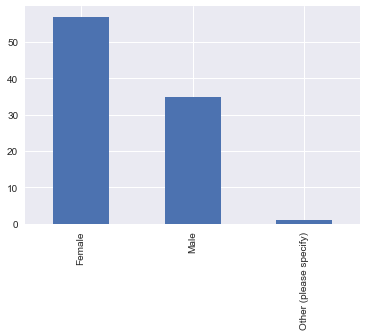

In [34]:
subjGenders.value_counts().plot(kind='bar')

For purposes of including 'gender' as a factor in the model, exclude the one 'other' response

In [35]:
df = df[(df.gender == 'Male') | (df.gender == 'Female')]

In [36]:
subjHandedness = df.groupby('subjID').apply(lambda x: x['handedness'].iloc[0])

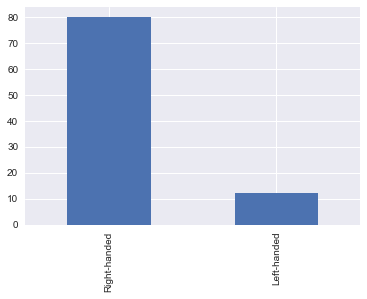

In [37]:
subjHandedness.value_counts().plot(kind='bar')

## Plot eyeBias by stim Category

In [38]:
sns.set_style('whitegrid')
matplotlib.rc('ytick', labelsize=15)
matplotlib.rc('xtick', labelsize=15)

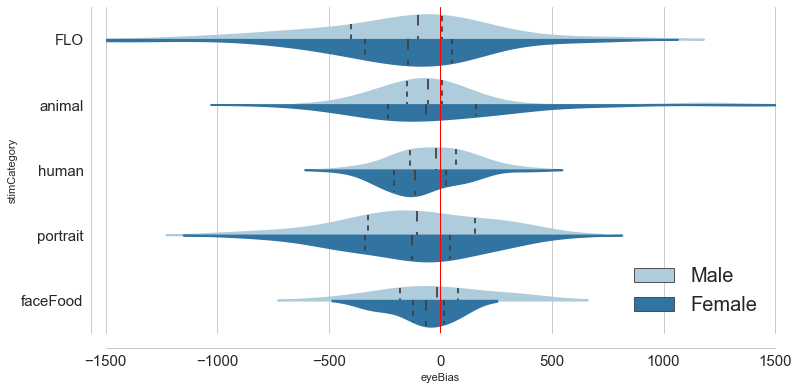

In [39]:
# plot by stim category and gender
fig = plt.figure(figsize=(12,6))

sns.violinplot(x='eyeBias', y='stimCategory', hue='gender', 
               data=df, split='True',
              inner='quartile', palette='Paired')
sns.despine(offset=15)


plt.legend(loc=4, prop={'size':20})
plt.gca().set_xlim(-1500, 1500)

plt.axvline(x=0, lw=1, c='red')

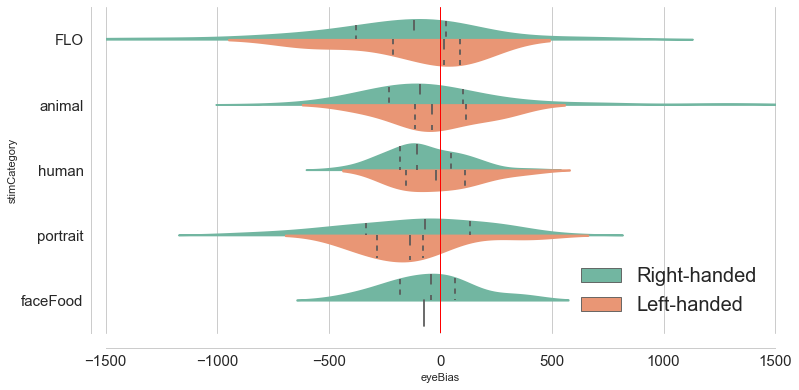

In [40]:
# plot by stim category and handedness
fig = plt.figure(figsize=(12,6))

sns.violinplot(x='eyeBias', y='stimCategory', hue='handedness', 
               data=df, split='True',
              inner='quartile', palette='Set2')
sns.despine(offset=15)

plt.legend(loc=4, prop={'size':20})
plt.gca().set_xlim(-1500, 1500)

plt.axvline(x=0, lw=1, c='red')

### Build a model predicting eyeBias 

In [41]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot


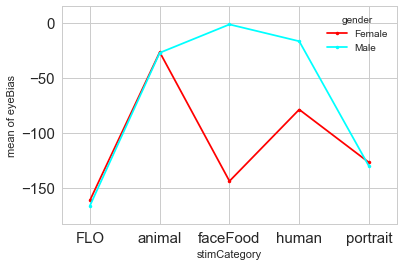

In [42]:
fig = interaction_plot(df.stimCategory, df.gender, df.eyeBias)

In [43]:
formula = 'eyeBias ~ 0 + C(gender) + C(handedness) + C(stimCategory)'
lm = ols(formula, df).fit()
aov_table = anova_lm(lm, typ=2)
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                eyeBias   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     1.997
Date:                Mon, 26 Jun 2017   Prob (F-statistic):             0.0659
Time:                        13:56:54   Log-Likelihood:                -2200.3
No. Observations:                 308   AIC:                             4415.
Df Residuals:                     301   BIC:                             4441.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
C(gender)[Fema

In [44]:
print(aov_table)

                       sum_sq     df         F    PR(>F)
C(gender)        7.205052e+05    2.0  3.748936  0.024649
C(handedness)    5.454235e+04    1.0  0.567590  0.451807
C(stimCategory)  1.080719e+06    4.0  2.811601  0.025702
Residual         2.892448e+07  301.0       NaN       NaN


In [45]:
lm.model.data.orig_exog[:10]

,C(gender)[Female],C(gender)[Male],C(handedness)[T.Right-handed],C(stimCategory)[T.animal],C(stimCategory)[T.faceFood],C(stimCategory)[T.human],C(stimCategory)[T.portrait]
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,1.0,1.0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,0.0,1.0,0.0
3,0.0,1.0,1.0,0.0,0.0,0.0,1.0
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0
5,0.0,1.0,1.0,1.0,0.0,0.0,0.0
6,0.0,1.0,1.0,0.0,0.0,1.0,0.0
7,0.0,1.0,1.0,0.0,0.0,0.0,1.0
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.0,0.0,0.0,1.0,0.0,0.0,0.0
